In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


## 1. Undersampling Majority Class
This technique **reduces the number of examples** in the larger (majority) class to balance the dataset. It's like throwing out random, redundant photos of cats to have an equal number of cat and dog pictures. The drawback is that you risk **losing valuable information** from the deleted majority samples.

<br>

## 2. Oversampling Minority Class
This technique **increases the number of examples** in the smaller (minority) class to balance the dataset. It's done by simply **duplicating** the existing minority samples. While easy, it can lead to **overfitting** because the model sees the exact same copies repeatedly.

<br>

## 3. Oversampling Minority Class Using SMOTE (Synthetic Minority Oversampling Technique)
SMOTE is a smarter way to oversample. Instead of duplicating existing minority samples, SMOTE **creates new, synthetic samples** that are slight variations of the existing ones. It does this by finding two similar minority samples, drawing a line between them, and placing a new data point somewhere on that line. This reduces overfitting compared to simple duplication.

<br>

## 4. Ensemble Method
This involves **combining multiple individual models** (called "base learners") to get a final prediction, which is generally more accurate and robust than any single model. In imbalanced data, this often involves methods like **Bagging** or **Boosting** where each model focuses on different parts of the data (sometimes undersampled subsets) to ensure the minority class isn't ignored.

<br>

## 5. Focal Loss
Focal Loss is a **specialized loss function** used primarily in deep learning for highly imbalanced classification problems. It works by **down-weighting the loss contribution from easy-to-classify examples** (typically majority class samples) and **focusing the model's training attention on hard-to-classify examples** (often the minority class or confusing boundary samples). This forces the network to learn better features for the rare class instead of becoming lazy and just predicting the majority class.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

2025-10-07 13:39:42.607651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759844382.886067      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759844382.964219      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import kagglehub
from kagglehub.datasets import KaggleDatasetAdapter

# The handle remains the same
handle = "blastchar/telco-customer-churn"

# The path must now be the actual filename within the dataset
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv" 

# Load the dataset
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  handle,
  path=file_path  
)

# Display the first few rows to confirm loading

In [4]:
df.drop('customerID', axis=1, inplace=True)

In [5]:
df.TotalCharges.values
# df['TotalCharges'] = df['TotalCharges'].astype('int') We can use this technique also

# pd.to_numeric(df.TotalCharges)
# Have to remove the spaces in the values 

pd.to_numeric(df.TotalCharges,errors='coerce').isnull().sum()
print(df.shape)

(7043, 20)


In [6]:
df.iloc[488]['TotalCharges']

' '

In [7]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [8]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)
print(df1.TotalCharges.head())
print(df1.TotalCharges.dtype)

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64
float64


In [9]:
# To replace the values that you want in the column, you can do this

df1.replace('No phone service', 'No', inplace=True)
df1.replace('No internet service', 'No', inplace=True)

In [10]:
yes_no_cols = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

In [11]:
for col in yes_no_cols:
    df1[col] = df1[col].replace({"Yes": 1, "No": 0})

In [12]:
df1['gender'] = df1['gender'].replace({'Female':1, 'Male':0})

In [13]:
df2 = pd.get_dummies(data = df1, columns=['InternetService', 'Contract', 'PaymentMethod'])
df2.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6860,1,0,0,0,37,1,1,0,1,1,...,False,True,False,True,False,False,True,False,False,False
3297,1,0,1,0,42,1,1,1,0,1,...,True,False,False,False,False,True,False,True,False,False
1125,0,1,1,0,39,1,1,0,1,1,...,False,True,False,True,False,False,False,False,True,False


In [14]:
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()

df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

df2.shape

(7032, 27)

In [15]:
X = df2.drop('Churn', axis=1)
y = df2['Churn']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [17]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(26, input_shape = (26, ), activation='relu'),
    
    keras.layers.Dense(26, activation='relu'),
    keras.layers.Dense(26, activation='relu'),

    # Output layer
    keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.fit(X_train, y_train, epochs=5)

Epoch 1/5


2025-10-07 13:40:00.076155: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7166 - loss: 0.5748
Epoch 2/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7909 - loss: 0.4310
Epoch 3/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8102 - loss: 0.4121
Epoch 4/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.4059
Epoch 5/5
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8146 - loss: 0.4020


In [18]:
val_loss, val_acc = model.evaluate(X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.4335


In [19]:
yp = model.predict(X_test)
yp[:5]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.00935413],
       [0.1532785 ],
       [0.55958027],
       [0.12284532],
       [0.25708812]], dtype=float32)

In [20]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

[[934  99]
 [194 180]]


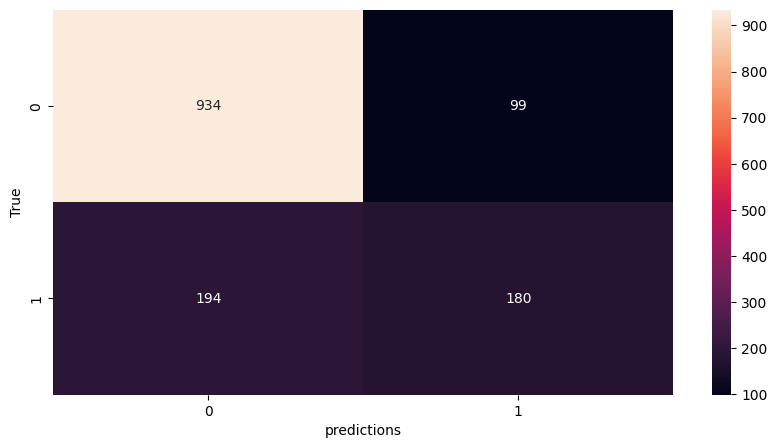

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

plt.figure(figsize = (10, 5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("predictions")
plt.ylabel("True")

print(confusion_matrix(y_test, y_pred))

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



## Improving the balance of the dataset

In [23]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_shape = (26, ), activation='relu'),
        
        keras.layers.Dense(26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
    
        # Output layer
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    model.compile(
        optimizer = 'Adam',
        loss = loss,
        metrics = ['accuracy']
    )

    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=5, class_weights = weights)

    print(model.evaluate(X_test, y_test))

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)

    print(f"Classification report: {classification_report(y_test, y_pred)}")

    return y_pred

In [25]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6983 - loss: 0.5783
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4334
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4313
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8032 - loss: 0.4137
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7919 - loss: 0.4209
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4124
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8088 - loss: 0.3982
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8170 - loss: 0.4008
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8185 - loss: 0.3931
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8173 - loss: 0.3952
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8166 - loss: 0.3933
Epoch 12/100
176/176 ━━━━━━━━━━━━━━━━━━━━

## Methond 1: **UnderSampling** ##

In [26]:
df2.Churn.value_counts()

# As you can see the data is imbalanced

Churn
0    5163
1    1869
Name: count, dtype: int64

In [27]:
count_class_0, count_class_1 = df2.Churn.value_counts()

# Devide the classes into 1 and 0
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

df_class_0.shape, df_class_1.shape

((5163, 27), (1869, 27))

In [28]:
df_class_0_under = df_class_0.sample(count_class_1)
df_class_0_under.shape

# now concatinate to create a dataset
print("Random-Under sampling:")
df_test_under = pd.concat([df_class_0_under, df_class_1], axis = 0)
print(df_test_under.Churn.value_counts())

# Now you can see the dataset is equally balanced

Random-Under sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


In [29]:
X = df_test_under.drop('Churn', axis=1)
y = df_test_under['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
X_train.shape, y_train.shape

((2990, 26), (2990,))

In [31]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6154 - loss: 0.6550
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7385 - loss: 0.5308
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.4830
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.4779
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.4892
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7581 - loss: 0.4978
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7691 - loss: 0.4753
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.4838
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7766 - loss: 0.4776
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.4570
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.4592
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

As you can see, the f1-score is balanced and precision, recall is very good, and it is correctly fiited

## Methond 2: **OverSampling** ##

In [32]:
count_class_0, count_class_1 

(5163, 1869)

In [33]:
df_class_0.shape, df_class_1.shape

# as the df_class_1 is having low number of classes, we'll increase the number of datasets

((5163, 27), (1869, 27))

In [34]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_1_over.shape
# here random samples are created from the existing 1869 data

(5163, 27)

In [35]:
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print("Random-Sample oversampling:")
df_test_over.Churn.value_counts()

Random-Sample oversampling:


Churn
0    5163
1    5163
Name: count, dtype: int64

In [36]:
X = df_test_over.drop('Churn', axis=1)
y = df_test_over['Churn']

X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)

(8260, 26) (8260,)


In [37]:
y_train.value_counts()

Churn
0    4130
1    4130
Name: count, dtype: int64

In [38]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6918 - loss: 0.5973
Epoch 2/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7637 - loss: 0.4942
Epoch 3/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7654 - loss: 0.4857
Epoch 4/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.4807
Epoch 5/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7685 - loss: 0.4745
Epoch 6/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7618 - loss: 0.4791
Epoch 7/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7646 - loss: 0.4742
Epoch 8/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7709 - loss: 0.4719
Epoch 9/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7757 - loss: 0.4612
Epoch 10/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7645 - loss: 0.4666
Epoch 11/100
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7815 - loss: 0.4575
Epoch 12/100
259/259 ━━━━━━━━━━━━━━━━━━━━

## Methond 3: **SMOTE** ##

In [39]:
X = df2.drop('Churn', axis=1)
y = df2['Churn']

y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [40]:
!pip install --upgrade scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 59.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts()

In [ ]:
X_train, X_test, y_train ,y_test = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)

In [ ]:
y_train.value_counts()

In [ ]:
y_pred = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

## Methond 4: **Use of Ensemble with Undersamping** ##

In [46]:
df2.Churn.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [49]:
X = df2.drop('Churn', axis=1)
y = df2['Churn']

X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size=0.2, stratify=y)
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

In [51]:
4130 / 1495

# as you can see, it is approximately 3, so we can build 3 models and take average of it

2.762541806020067

In [52]:
4130 / 3

1376.6666666666667

In [54]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [56]:
df3_class_0 = df3[df3['Churn'] == 0]
df3_class_1 = df3[df3['Churn'] == 1]

df3_class_0.shape, df3_class_1.shape

((4130, 27), (1495, 27))

In [70]:
def get_train_batch(df_majority, df_minority, start ,end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)
    
    X_train = df_train.drop('Churn', axis=1)
    y_train = df_train['Churn']

    return X_train, y_train

In [71]:
X_train ,y_train = get_train_batch(df3_class_0, df3_class_1, 0, 1495)
X_train.shape, y_train.shape

((2990, 26), (2990,))

In [72]:
y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6361 - loss: 0.6555
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7507 - loss: 0.5185
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.4745
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7456 - loss: 0.5170
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7688 - loss: 0.4759
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.4783
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7748 - loss: 0.4635
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7847 - loss: 0.4691
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7758 - loss: 0.4770
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7833 - loss: 0.4627
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7931 - loss: 0.4552
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [73]:
X_train ,y_train = get_train_batch(df3_class_0, df3_class_1, 1495, 2990)
X_train.shape, y_train.shape

((2990, 26), (2990,))

In [74]:
y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6526 - loss: 0.6336
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7692 - loss: 0.5064
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.4800
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.4826
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7770 - loss: 0.4610
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7678 - loss: 0.4722
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - loss: 0.4647
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7756 - loss: 0.4618
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.4398
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7748 - loss: 0.4606
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.4622
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [75]:
X_train ,y_train = get_train_batch(df3_class_0, df3_class_1, 2990, 4130)
X_train.shape, y_train.shape

((2635, 26), (2635,))

In [76]:
y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6273 - loss: 0.6480
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646 - loss: 0.5071
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.4685
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.4794
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7715 - loss: 0.4768
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.4535
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7837 - loss: 0.4548
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7875 - loss: 0.4592
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.4554
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7842 - loss: 0.4587
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7855 - loss: 0.4650
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [78]:
# take majority votes of 3 predicted models

vote1 = 1
vote2 = 1
vote3 = 1

vote1+vote2+vote3


3

In [83]:
y_pred_final = y_pred1.copy()

for i in range(len(y_pred1)):
    n_ones = y_pred[i] + y_pred2[i] + y_pred3[i]
    if n_ones > 1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [85]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.88      0.62      0.73      1033
           1       0.42      0.76      0.54       374

    accuracy                           0.66      1407
   macro avg       0.65      0.69      0.63      1407
weighted avg       0.76      0.66      0.68      1407

